In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from scipy.signal import detrend
from eofs.xarray import Eof
#import iris
#from eofs.multivariate.iris import MultivariateEof
#import iris.quickplot as qplt
from tempfile import TemporaryFile
import time
import gc
import os
import datetime
import pandas as pd

D:\Programme\Anaconda\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
D:\Programme\Anaconda\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
home_path = r'D:\Thomas\Dokumente\Studium\Meteorologie\Master\4. Semester\Klima 1'

ds_analoga = xr.open_mfdataset(home_path+'/Projekt\Analog_method/Analoga_ranked_pro_TD.nc')#,combine='by_coords')
ds_analoga = ds_analoga.sel(TD = ds_analoga.TD.dt.year.isin(np.arange(1961,2018,1)))
print(ds_analoga)

ds_sparta = xr.open_mfdataset(home_path+'/Data/Spartacus/Tx/*.nc')#,combine='by_coords')
ds_sparta = ds_sparta.sel(time=~((ds_sparta.time.dt.month == 2) & (ds_sparta.time.dt.day == 29)))
print(ds_sparta.Tx_area_mean)

<xarray.Dataset>
Dimensions:        (TD: 20791, rank: 10)
Coordinates:
  * TD             (TD) datetime64[ns] 1961-01-01 1961-01-02 ... 2017-12-31
  * rank           (rank) int64 1 2 3 4 5 6 7 8 9 10
Data variables:
    analoga_dates  (TD, rank) datetime64[ns] dask.array<shape=(20791, 10), chunksize=(20791, 10)>
    analoga_norms  (TD, rank) float32 dask.array<shape=(20791, 10), chunksize=(20791, 10)>
<xarray.DataArray 'Tx_area_mean' (time: 20805)>
dask.array<shape=(20805,), dtype=float64, chunksize=(365,)>
Coordinates:
  * time     (time) datetime64[ns] 1961-01-01 1961-01-02 ... 2017-12-31
Attributes:
    units:        degree_Celsius
    long_name:    mean of variable Tx over Austrian territory
    description:  mean over Austria for each time step


In [6]:
TD_period = pd.date_range("2000-12-31","2001-02-28")

rmse_list = []
rmse_all = []
diff_list = []
diff_all = []
corr_list=[]
corr_all=[]
forecast_list = []
number_analoga = 10

k = 0
for TD in TD_period:
    observation = ds_sparta.Tx_area_mean.loc[TD]    

    for j in range(0,number_analoga):
        
        analoga_for = ds_analoga.analoga_dates.loc[TD][j]
        
        forecast = ds_sparta.Tx_area_mean.loc[analoga_for]
        rmse=np.sqrt((forecast.values-observation.values)**2)
        diff = (forecast.values - observation.values)
        
        rmse_list.append(rmse)
        diff_list.append(diff)
        forecast_list.append(forecast.values)
 
    rmse_all.append(rmse_list)
    diff_all.append(diff_list)
    rmse_list = []
    diff_list = []
    corr_list=[]
    
rmse_all = np.array(rmse_all)
diff_all = np.array(diff_all)
corr_all = np.array(corr_all)

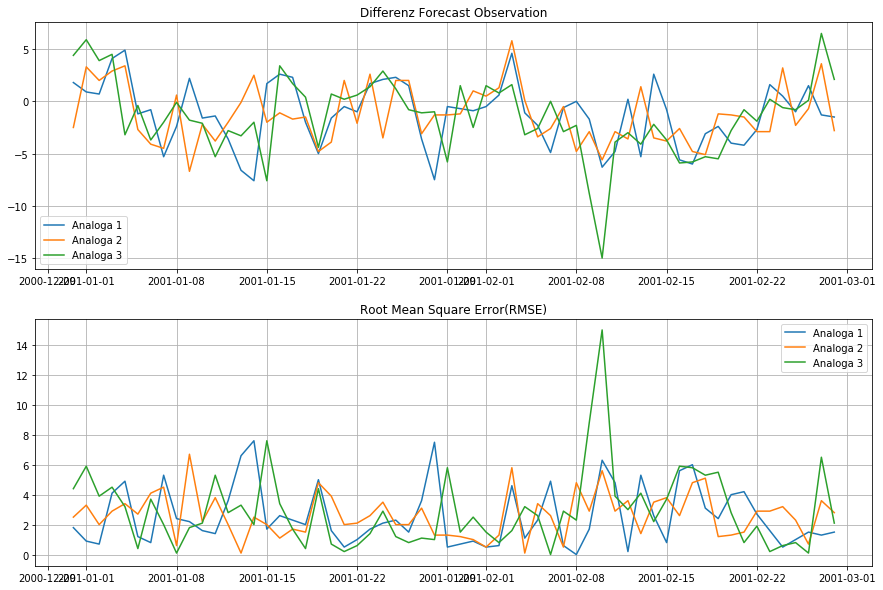

In [7]:
legend_string = []
for letter_index in range(1,number_analoga+1):
    legend_string.append("Analoga"+" "+str(letter_index))

fig=plt.figure(figsize=(15,10))
sub1=fig.add_subplot(211)
for n in range(0,number_analoga-7):
    plt.plot(TD_period,diff_all[:,n],label= str(legend_string[n]))
plt.legend()
plt.title("Differenz Forecast Observation")
plt.grid()
sub1=fig.add_subplot(212)
for n in range(0,number_analoga-7):
    plt.plot(TD_period,rmse_all[:,n],label= str(legend_string[n]))
plt.legend()
plt.title("Root Mean Square Error(RMSE)")
plt.grid()
plt.savefig("valid.png",dpi=152)

In [9]:
print("RMSE:",np.mean(rmse_all[:,0]),np.mean(rmse_all[:,1]),np.mean(rmse_all[:,2]))
print("BIAS:",np.mean(diff_all[:,0]),np.mean(diff_all[:,1]),np.mean(diff_all[:,2]))

RMSE: 2.5716667489459115 2.633333392813802 2.9416667375713588
BIAS: -1.2250000334034363 -1.2933333529780309 -1.4250000552584727
